## Vanilla RNN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Plotting sin curve

In [2]:
x_t = np.linspace(0,60,300)
y_t = np.sin(x_t)

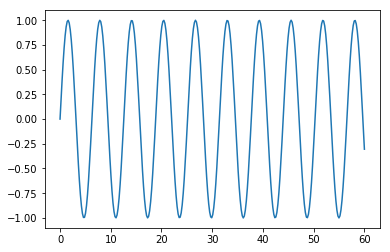

In [3]:
plt.plot(x_t,y_t)

### Setting up data pipeline

> **Seq length** is an important parameter. Each sample should be of a SEQ length that covers more than one cycle of sinwave (also depends on resolution of linspace). Otherwise, we get abnormal results while serving

In [4]:
SEQ = 100
HIDDEN = 100
INP_SIZE=1

**Generator**

In [5]:
def generator():
    x = np.linspace(0,60,300)
    for i in range(2000):
        idx = np.random.randint(0,200) #scalar
        yield (x[idx:idx+SEQ],np.sin(x[idx:idx+SEQ]))

Check one sample

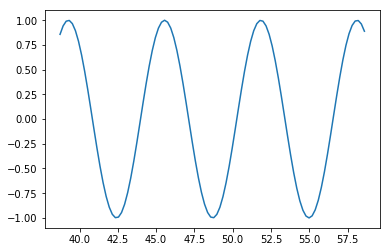

In [6]:
for i in generator():
    plt.plot(i[0],i[1])
    break

**tf.data.Dataset**

In [7]:
dataset = tf.data.Dataset.from_generator(generator,(tf.float32,tf.float32),((SEQ,),(SEQ,)))
dataset = dataset.repeat(3)
dataset = dataset.batch(1)

In [8]:
iterator = dataset.make_one_shot_iterator()
idx,sin_x = iterator.get_next()
sin_x.shape

TensorShape([Dimension(None), Dimension(100)])

Check

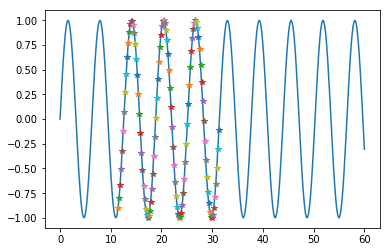

In [9]:
with tf.Session() as sess:
    x_,y_ = sess.run([idx,sin_x])
    plt.plot(x_t,y_t)
    plt.plot(x_,y_,'*')

### Input and Target

In [10]:
X = sin_x[:,:-1]
target = sin_x[:,1:]
X,target

(<tf.Tensor 'strided_slice:0' shape=(?, 99) dtype=float32>,
 <tf.Tensor 'strided_slice_1:0' shape=(?, 99) dtype=float32>)

### A) Manual coding of RNN Cell

> h_next = activation(Whh x h + Whx x x + b)

> y = Wyh x h_next

In [12]:
def RNNCell(x:'Input Tensor [batch,1]',h:'Hidden state tensor [batch,hidden size]'):
    inp_size = x.shape[1]
    hidden_size = h.shape[1]
    with tf.variable_scope('params',reuse=tf.AUTO_REUSE):
        Whh = tf.get_variable("Whh",shape=(hidden_size,hidden_size),dtype=tf.float32,initializer=tf.initializers.orthogonal())
        Whx = tf.get_variable("Whx",shape=(inp_size,hidden_size),dtype=tf.float32,initializer=tf.initializers.glorot_uniform())
        b = tf.get_variable("b",shape=(hidden_size,),dtype=tf.float32,initializer=tf.initializers.zeros())
        
    h_next = tf.nn.relu(tf.add(tf.add(tf.matmul(h,Whh),tf.matmul(x,Whx)),b))
    return h_next  

**Unroll the cell**

In [13]:
l = []
h = tf.zeros((tf.shape(X)[0],HIDDEN)) #Initial hidden state
for i in range(SEQ-1):
    with tf.variable_scope("RNN"):
        x = tf.reshape(X[:,i],(tf.shape(X)[0],1)) #(Batch,1)
        h_next = RNNCell(x,h)
        h = h_next
        l.append(h)

In [14]:
H = tf.convert_to_tensor(l)
H

<tf.Tensor 'packed:0' shape=(99, ?, 100) dtype=float32>

This is done outside the loop for efficiency

In [15]:
outputs = tf.layers.dense(H,1,activation=tf.nn.tanh)
outputs

<tf.Tensor 'dense/Tanh:0' shape=(99, ?, 1) dtype=float32>

In [16]:
outputs = tf.transpose(outputs,(1,0,2))
outputs = tf.reshape(outputs,(-1,SEQ-1))
outputs

<tf.Tensor 'Reshape:0' shape=(?, 99) dtype=float32>

### Loss and optimizer

In [17]:
target,outputs

(<tf.Tensor 'strided_slice_1:0' shape=(?, 99) dtype=float32>,
 <tf.Tensor 'Reshape:0' shape=(?, 99) dtype=float32>)

In [18]:
tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

[<tf.Variable 'RNN/params/Whh:0' shape=(100, 100) dtype=float32_ref>,
 <tf.Variable 'RNN/params/Whx:0' shape=(1, 100) dtype=float32_ref>,
 <tf.Variable 'RNN/params/b:0' shape=(100,) dtype=float32_ref>,
 <tf.Variable 'dense/kernel:0' shape=(100, 1) dtype=float32_ref>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32_ref>]

In [19]:
loss = tf.reduce_mean(tf.square(outputs-target))

In [20]:
optimizer = tf.train.AdamOptimizer(0.0001)
train = optimizer.minimize(loss)

### Training

In [21]:
saver = tf.train.Saver()

In [22]:
!rm models/RNN/*

In [11]:
def train_rnn():
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        try:
            i = 1
            tmp = []
            while True:
                i = i+1
                l,_ = sess.run([loss,train])
                tmp.append(l)
                if i%500 == 0:
                    avg_loss = np.array(tmp).mean()
                    print("Batch: ",i,avg_loss)
                    tmp = []

        except tf.errors.OutOfRangeError:
            pass
        saver.save(sess,'models/RNN/my_first_model.ckpt')

In [24]:
train_rnn()

Batch:  500 0.05869313
Batch:  1000 0.006380457
Batch:  1500 0.004031862
Batch:  2000 0.0028954989
Batch:  2500 0.002198836
Batch:  3000 0.0017565825
Batch:  3500 0.0013892506
Batch:  4000 0.0011569529
Batch:  4500 0.0009854711
Batch:  5000 0.0008979512
Batch:  5500 0.0007867349
Batch:  6000 0.00071768474


### Evaluation

In [12]:
def val():
    with tf.Session() as sess:
        saver.restore(sess,'models/RNN/my_first_model.ckpt')   
        try:
            while True:
                o,t = sess.run([outputs,target])
                plt.plot(o[0],'*')
                plt.plot(t[0])
                break

        except tf.errors.OutOfRangeError:
            pass

INFO:tensorflow:Restoring parameters from models/RNN/my_first_model.ckpt


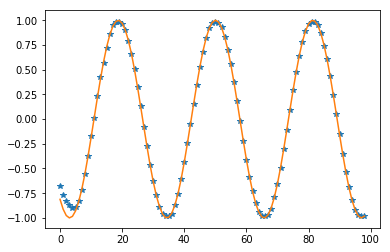

In [26]:
val()

### Serving

The sequence length to be generated should be same as that with which it was trained! Otherwise, we see abnormal behaviour

In [28]:
h = tf.zeros((1,HIDDEN)) #Initial hidden state
x = tf.constant([[0.1]],dtype=tf.float32)
W_d = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='dense/kernel:0')[0]
b_d = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope='dense/bias:0')[0]
out = []
for i in range(SEQ):
    with tf.variable_scope("RNN"):
        h_next = RNNCell(x,h)
        x = tf.tanh(tf.add(tf.matmul(h_next,W_d),b_d))
        out.append(x)
        h = h_next

In [29]:
with tf.Session() as sess:
    saver.restore(sess,'models/RNN/my_first_model.ckpt')   
    o = sess.run(out)

INFO:tensorflow:Restoring parameters from models/RNN/my_first_model.ckpt


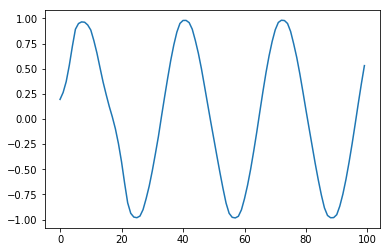

In [30]:
o = np.array(o).reshape(SEQ)
plt.plot(o)

### B) Using Built-in functions

> Much slower. Probably because the output matmul is happening inside the loop

In [13]:
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=HIDDEN, activation=tf.nn.relu),
    output_size=1,activation=tf.nn.tanh)

outputs, states = tf.nn.dynamic_rnn(cell, tf.reshape(X,(-1,SEQ-1,1)), dtype=tf.float32)

outputs = tf.reshape(outputs,(-1,SEQ-1))

loss = tf.reduce_mean(tf.square(outputs-target))
optimizer = tf.train.AdamOptimizer(0.0001)
train = optimizer.minimize(loss)
saver = tf.train.Saver()

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [14]:
train_rnn()

Batch:  500 0.052127127
Batch:  1000 0.0066490984
Batch:  1500 0.004257348
Batch:  2000 0.0031505798
Batch:  2500 0.0024545982
Batch:  3000 0.0018710368
Batch:  3500 0.001574922
Batch:  4000 0.0013011103
Batch:  4500 0.0011270343
Batch:  5000 0.0009930291
Batch:  5500 0.00086758
Batch:  6000 0.0007896476


INFO:tensorflow:Restoring parameters from models/RNN/my_first_model.ckpt


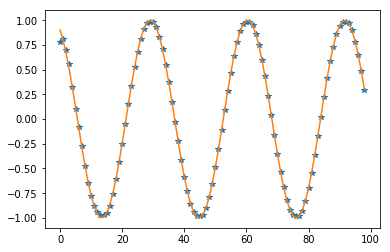

In [24]:
val()

### Serving 

Dont forget to pass the states around the loop

In [30]:
start = -0.1
x_ = tf.constant(np.array(start).reshape(1,1,1),dtype=tf.float32)
h = tf.zeros((1,HIDDEN))
out=[]
for i in range(SEQ):
    x_, h = tf.nn.dynamic_rnn(cell,x_, initial_state=h, dtype=tf.float32) #I think this is 
    out.append(x_)

INFO:tensorflow:Restoring parameters from models/RNN/my_first_model.ckpt


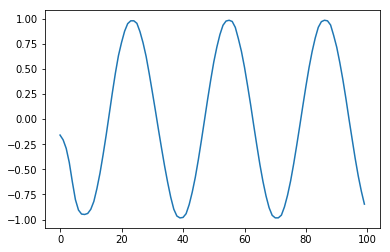

In [31]:
with tf.Session() as sess:
    saver.restore(sess,'models/RNN/my_first_model.ckpt')   
    o = sess.run(out)
o = np.array(o).reshape(SEQ)
plt.plot(o)

## Summary

>1) Make sure to use proper naming conventions. Had to debug for 5 hours cuz of overlooking data format obtained from **iterator.get_next()**

>2) **Seq length** is an important parameter. Each sample should be of a SEQ length that covers more than one cycle of sinwave (also depends on resolution of linspace). Otherwise, we get abnormal results while serving

>3) The sequence length to be generated while serving should be same as that with which it was trained! Otherwise, we see abnormal behaviour

>4) Dont forget to pass the hidden states around the loop while unrolling